# Coursework 1: Question 2 - Vodacom Dataset

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import logging
import re
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

## Source Data

Get the source data to use for clustering.

### Data Load

Load customers reviews that was previously downloaded from Hellopeter in the [DSM020](https://github.com/JohnnyFoulds/dsm020-2021-oct) git repository.

In [2]:
df_source = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/blob/master/coursework_01/data/output/telecommunications.gzip?raw=true')
df_source.shape

(35072, 17)

In [3]:
df_source.head(2)

id          created_at            author  \
0  3750417 2021-12-21 15:27:08           Barry S   
1  3750406 2021-12-21 15:19:45  Kulani Marry-Aan   

                              author_id                      review_title  \
0  05c6e290-6186-11ec-b1c0-cd74559df45d                     Worst Service   
1  0a616360-6260-11ec-b18f-0f0735b462a0  Complaint about customer service   

   review_rating                                     review_content  \
0              1  Worst service I’ve received in my life. Non of...   
1              1  18/12/2021 i bought a router at Vodacom Bushbu...   

  business_slug                                          permalink  replied  \
0       vodacom  worst-service-04099ff193227e2908f31413b00ffb30...    False   
1       vodacom  complaint-about-customer-service-28c9107344f3a...    False   

  messages       industry_slug  nps_rating author_created_date  \
0       []  telecommunications         NaN          2021-12-20   
1       []  telecommunications         NaN          2021-12-21   

   author_total_reviews_count                review_title_clean  \
0                           1                     Worst Service   
1                           1  Complaint about customer service   

                                review_content_clean  
0  Worst service I’ve received in my life. Non of...  
1  18/12/2021 i bought a router at Vodacom Bushbu...

### Data Selection

Select only reviews from `vodacom` with the `review_title` and `review_content_clean` being the only data of interest.

In [4]:
df_reviews = df_source.query('business_slug == "vodacom"')[['id', 'review_title', 'review_content_clean']].reset_index(drop=True)
df_reviews.shape

(13699, 3)

In [5]:
df_reviews.head(3)

id                                       review_title  \
0  3750417                                      Worst Service   
1  3750406                   Complaint about customer service   
2  3750373  VODACOM not living up to promises and just wan...   

                                review_content_clean  
0  Worst service I’ve received in my life. Non of...  
1  18/12/2021 i bought a router at Vodacom Bushbu...  
2  I need help with Vodacom.  I have been a custo...

### Data Preparation

Create an individual text file for each review for upload to HDFS.

In [6]:
def create_files(data:pd.DataFrame, output_path:str, id_column:str='id', title_column:str='review_title', content_column:str='review_content_clean') -> None:
    """
    Create a output .txt file for each review in the dataset.

    Parameters
    ----------
    data : pandas.DataFrame
        The DataFrame containint the reviews to process.

    output_path : str
        The path where the .txt files should be stored

    id_column : str
        The name of the ID column that will be used for the filename.

    title_column : str
        The name of the column in the DataFrame containing the review title.

    content_column : str
        The name of the column in the DataFrame containing the review text.
    """
    for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        # get the output filename
        filename = '%s/%s.txt' % (output_path, row[id_column])

        # get the text to write to file
        output_text = '%s\n\n%s' % (row[title_column], row[content_column])

        # create the output file
        with open(filename, 'w') as f:
            f.write(output_text)

# create the output files 
sample_size = 0.6
df_sample = df_reviews.sample(frac=sample_size, random_state=3231)
create_files(df_sample, 'data/input/vodacom')

  0%|          | 0/8219 [00:00<?, ?it/s]

## Hadoop Processing

### Upload Data Files to HDFS

In [7]:
%%bash
# change to the coursework directory
cd ~/code/dsm010-2021-oct/coursework_01/

# delete existing files
hadoop fs -rm -r dsm010/vodacom-corpus

# copy the input documents
 hadoop fs -copyFromLocal data/input/vodacom dsm010/vodacom-corpus

# verify the file uploads
hadoop fs -ls dsm010/vodacom-corpus | head -n 5

Deleted dsm010/vodacom-corpus
Found 8216 items
-rw-r--r--   3 jfoul001 users        496 2022-01-01 20:48 dsm010/vodacom-corpus/3337933.txt
-rw-r--r--   3 jfoul001 users        269 2022-01-01 20:48 dsm010/vodacom-corpus/3337940.txt
-rw-r--r--   3 jfoul001 users        268 2022-01-01 20:48 dsm010/vodacom-corpus/3337941.txt
-rw-r--r--   3 jfoul001 users        578 2022-01-01 20:47 dsm010/vodacom-corpus/3337954.txt


### Convert the dataset to SequenceFiles

SequenceFiles are flat files consisting of binary key/value pairs. Each document is represented as a key-value pair. there the key is the document id and value is its content.

In [8]:
%%bash
mahout seqdirectory \
    -i dsm010/vodacom-corpus \
    -o dsm010/vodacom-corpus-seqfiles \
    -ow \
    -c UTF-8 \
    -chunk 5

MAHOUT_LOCAL is not set; adding HADOOP_CONF_DIR to classpath.
Running on hadoop, using /opt/hadoop/current/bin/hadoop and HADOOP_CONF_DIR=/opt/hadoop/current/etc/hadoop
MAHOUT-JOB: /opt/mahout/current/mahout-examples-0.13.0-job.jar


22/01/01 20:49:07 INFO AbstractJob: Command line arguments: {--charset=[UTF-8], --chunkSize=[5], --endPhase=[2147483647], --fileFilterClass=[org.apache.mahout.text.PrefixAdditionFilter], --input=[dsm010/vodacom-corpus], --keyPrefix=[], --method=[mapreduce], --output=[dsm010/vodacom-corpus-seqfiles], --overwrite=null, --startPhase=[0], --tempDir=[temp]}
22/01/01 20:49:08 INFO HadoopUtil: Deleting dsm010/vodacom-corpus-seqfiles
22/01/01 20:49:08 INFO deprecation: mapred.input.dir is deprecated. Instead, use mapreduce.input.fileinputformat.inputdir
22/01/01 20:49:08 INFO deprecation: mapred.compress.map.output is deprecated. Instead, use mapreduce.map.output.compress
22/01/01 20:49:08 INFO deprecation: mapred.output.dir is deprecated. Instead, use mapreduce.output.fileoutputformat.outputdir
22/01/01 20:49:08 INFO DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at lena-master/128.86.245.64:8032
22/01/01 20:49:08 INFO JobResourceUploader: Disabling Erasure Coding for path:

### Convert sequenceFiles to sparse vector files

In [9]:
%%bash
mahout seq2sparse \
    -nv \
    -i dsm010/vodacom-corpus-seqfiles \
    -o dsm010/vodacom-corpus-vectors \
    -ow

MAHOUT_LOCAL is not set; adding HADOOP_CONF_DIR to classpath.
Running on hadoop, using /opt/hadoop/current/bin/hadoop and HADOOP_CONF_DIR=/opt/hadoop/current/etc/hadoop
MAHOUT-JOB: /opt/mahout/current/mahout-examples-0.13.0-job.jar


22/01/01 20:49:44 INFO SparseVectorsFromSequenceFiles: Maximum n-gram size is: 1
22/01/01 20:49:44 INFO HadoopUtil: Deleting dsm010/vodacom-corpus-vectors
22/01/01 20:49:44 INFO SparseVectorsFromSequenceFiles: Minimum LLR value: 1.0
22/01/01 20:49:44 INFO SparseVectorsFromSequenceFiles: Number of reduce tasks: 1
22/01/01 20:49:44 INFO SparseVectorsFromSequenceFiles: Tokenizing documents in dsm010/vodacom-corpus-seqfiles
22/01/01 20:49:44 INFO DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at lena-master/128.86.245.64:8032
22/01/01 20:49:45 INFO JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/jfoul001/.staging/job_1626049283275_242076
22/01/01 20:49:45 INFO FileInputFormat: Total input files to process : 2
22/01/01 20:49:45 INFO JobSubmitter: number of splits:2
22/01/01 20:49:45 INFO JobSubmitter: Submitting tokens for job: job_1626049283275_242076
22/01/01 20:49:45 INFO JobSubmitter: Executing with tokens: []
22/01/01 20:49:45 INFO Co

### Perform Clustering

Perform clustering and output data to perform hyperparameter optimization by trying various distance measures and values of K.

In [10]:
%%bash
#!/bin/bash

# range to use for k
k_start=2
k_end=20

# the path to the vectors and dictionary
path_vectors=dsm010/vodacom-corpus-vectors/tf-vectors
path_dictionary=dsm010/vodacom-corpus-vectors/dictionary.file-*

# the output base path for the clusters and the result local output path
path_hdfs_base=hdfs://lena/user/jfoul001/
path_clusters_base=dsm010/vodacom-corpus-kmeans
path_results_base=~/code/dsm010-2021-oct/coursework_01/data/output/vodacom-corpus-clusters

# the distance metric to use
distance_metrics=("org.apache.mahout.common.distance.CosineDistanceMeasure" "org.apache.mahout.common.distance.EuclideanDistanceMeasure" "org.apache.mahout.common.distance.SquaredEuclideanDistanceMeasure" "org.apache.mahout.common.distance.ManhattanDistanceMeasure")

for distance_metric in "${distance_metrics[@]}"
do
  echo "--- Distance Metric: $distance_metric"

    # perform the canopy clustering
    distance_name=${distance_metric##*.}
    path_centroids=dsm010/vodacom-corpus-canopy-centroids/${distance_name}

    mahout canopy \
      -i $path_vectors \
      -ow \
      -o $path_centroids \
      -dm $distance_metric \
      -t1 0.5 \
      -t2 0.3

  for ((k = $k_start; k <= $k_end; k++))
  do
    # get k with a leading zero if required
    k_padded=$(printf %02d $k)

    # set the output path for the clusters
    path_clusters="${path_clusters_base}/${distance_name}/${k_padded}"

    echo "---- K: $k_padded -- $path_clusters"

    # perform the kmeans clustering
    mahout kmeans \
    -i $path_vectors \
    -c $path_centroids \
    -o "${path_hdfs_base}${path_clusters}" \
    -ow \
    -dm $distance_metric \
    -cl -cd 0.1 -ow -x 20 \
    -k $k

    # set the path for output
    path_final_clusters=`hadoop fs -ls -d -C "${path_clusters}/clusters-*-final"`
    path_clusterpoints="${path_clusters}/clusteredPoints"
    path_results="${path_results_base}/${distance_name}/${k_padded}.txt"

    # output the cluster results
    mahout clusterdump -dt sequencefile \
       -d $path_dictionary \
       -i $path_final_clusters  \
       -o $path_results \
       -of TEXT \
       -b 100 \
       -p $path_clusterpoints \
       -dm $distance_metric \
       -n 20 --evaluate
  done  
done

--- Distance Metric: org.apache.mahout.common.distance.CosineDistanceMeasure
MAHOUT_LOCAL is not set; adding HADOOP_CONF_DIR to classpath.
Running on hadoop, using /opt/hadoop/current/bin/hadoop and HADOOP_CONF_DIR=/opt/hadoop/current/etc/hadoop
MAHOUT-JOB: /opt/mahout/current/mahout-examples-0.13.0-job.jar
---- K: 02 -- dsm010/vodacom-corpus-kmeans/CosineDistanceMeasure/02
MAHOUT_LOCAL is not set; adding HADOOP_CONF_DIR to classpath.
Running on hadoop, using /opt/hadoop/current/bin/hadoop and HADOOP_CONF_DIR=/opt/hadoop/current/etc/hadoop
MAHOUT-JOB: /opt/mahout/current/mahout-examples-0.13.0-job.jar
MAHOUT_LOCAL is not set; adding HADOOP_CONF_DIR to classpath.
Running on hadoop, using /opt/hadoop/current/bin/hadoop and HADOOP_CONF_DIR=/opt/hadoop/current/etc/hadoop
MAHOUT-JOB: /opt/mahout/current/mahout-examples-0.13.0-job.jar
---- K: 03 -- dsm010/vodacom-corpus-kmeans/CosineDistanceMeasure/03
MAHOUT_LOCAL is not set; adding HADOOP_CONF_DIR to classpath.
Running on hadoop, using /opt

22/01/01 20:57:03 INFO AbstractJob: Command line arguments: {--distanceMeasure=[org.apache.mahout.common.distance.CosineDistanceMeasure], --endPhase=[2147483647], --input=[dsm010/vodacom-corpus-vectors/tf-vectors], --method=[mapreduce], --output=[dsm010/vodacom-corpus-canopy-centroids/CosineDistanceMeasure], --overwrite=null, --startPhase=[0], --t1=[0.5], --t2=[0.3], --tempDir=[temp]}
22/01/01 20:57:04 INFO HadoopUtil: Deleting dsm010/vodacom-corpus-canopy-centroids/CosineDistanceMeasure
22/01/01 20:57:04 INFO CanopyDriver: Build Clusters Input: dsm010/vodacom-corpus-vectors/tf-vectors Out: dsm010/vodacom-corpus-canopy-centroids/CosineDistanceMeasure Measure: org.apache.mahout.common.distance.CosineDistanceMeasure@4ade6987 t1: 0.5 t2: 0.3
22/01/01 20:57:04 INFO DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at lena-master/128.86.245.64:8032
22/01/01 20:57:04 INFO JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/jfoul001/.staging/job_16

## Analysis

### Data Extraction

Extract data for analysis from the Mahout cluster dumps. 

> ℹ️ Although Mahout includes the option to produce data in JSON format which would have been easier to process, when the JSON format is used the distances to data points are excluded.

In [2]:
# configure logging for debugging
debug = False
logging.basicConfig(filename='cw01_q01_analysis_log.txt', level=logging.INFO)

if (debug):
    # define a Handler which writes INFO messages or higher to the sys.stderr
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)

    # add the handler to the root logger
    logging.getLogger('').addHandler(console)

In [31]:
class MahoutDataExtract():
    """
    This class is used to extract data from files produced with `mahout clusterdump`.
    """
    def process_file(self, file_path:str) -> tuple:
        """
        Process the file at specified path and extract the relevant data.

        Returns
        -------
        output_data : pandas.DataFrame
            The DataFrame will contain the following columns: cluster_identifier, point_distance, inter_cluster_density, intra_cluster_density
        """
        logging.info('- Processing: %s' % file_path)

        raw_data = []
        current_cluster = None
        inter_cluster_density = None
        intra_cluster_density = None

        # load the values from the text file
        with open(file_path) as file:
            while (line := file.readline()):
                if cluster_identifier := re.search(r'^:{"identifier":"(.+?)"', line): # start of a new cluster
                    current_cluster = cluster_identifier.group(1)
                    logging.info('-- Cluster: %s' % current_cluster)
                elif point_distance := re.match(r'^\s*.+? : \[distance=(.+?)\]', line): # handle a point in the cluster
                    point_distance = float(point_distance.group(1))
                    #logging.info('--- Point: %s' % point_distance)

                    # add the point to the raw data
                    raw_data.append({
                        'cluster_identifier': current_cluster,
                        'point_distance': point_distance
                    })
                elif density_match := re.match(r'^Inter-Cluster Density:\s(.+)', line): # match the inter density line
                    inter_cluster_density = density_match.group(1)
                    logging.info('--- Inter-Cluster Density: %s', inter_cluster_density)
                elif density_match := re.match(r'^Intra-Cluster Density:\s(.+)', line): # match the inter density line
                    intra_cluster_density = density_match.group(1)
                    logging.info('--- Intra-Cluster Density: %s', intra_cluster_density)

        # create the output dataframe
        output_data = pd.DataFrame(raw_data)
        output_data['inter_cluster_density'] = inter_cluster_density
        output_data['intra_cluster_density'] = intra_cluster_density

        # return the output values
        return output_data

    def process_distance_folder(self, folder_path:str) -> pd.DataFrame:
        """
        Process a distance folder containing the files for each value of K.

        Parameters
        ----------
        folder_path : str
            The path of the folder to process.

        Returns
        -------
        output_data : pandas.DataFrame
            The combined output of each file processed in the folder.
        """
        output_data = pd.DataFrame()

        # get the name of the distance measure from the folder path
        distance_measure = os.path.split(folder_path)[-1].replace('DistanceMeasure', '')
        logging.info('- Distance Measure: %s' % distance_measure)

        # process each file
        for file_path in os.listdir(folder_path):
            # get the data for the folder
            folder_data = self.process_file('%s/%s' % (folder_path, file_path))
            
            folder_data['distance_measure'] = distance_measure
            folder_data['k'] = file_path.replace('.txt', '')
            output_data = pd.concat([output_data, folder_data])
        
        # return the output dataframe
        return output_data.reset_index(drop=True)

    def process_cluster_folder(self, folder_path:str) -> pd.DataFrame:
        """
        Process a cluster folder with distance measures, and below that k values as sub folders.

        Parameters
        ----------
        folder_path : str
            The path of the folder to process.

        Returns
        -------
        output_data : pandas.DataFrame
            The combined output of processesing all cluster data output.
        """
        output_data = pd.DataFrame()

        # process each folder
        for file_path in os.listdir(folder_path):
            logging.info(file_path)     

            # get the data for the folder
            folder_data = self.process_distance_folder('%s/%s' % (folder_path, file_path))
            output_data = pd.concat([output_data, folder_data])

        # return the output dataframe
        return output_data.reset_index(drop=True)


# extract the experiment values
extractor = MahoutDataExtract()
df_experiment = extractor.process_cluster_folder('data/output/vodacom-corpus-clusters')
#df_experiment = extractor.process_cluster_folder('data/output/british-fiction-corpus-clusters')
df_experiment.sample(n=10)

cluster_identifier  point_distance inter_cluster_density  \
399071            VL-4895       12.020870    0.2266205478723883   
586596            VL-1619        6.573213   0.27237803975392905   
294317            VL-3351      169.025579    0.6481449179632249   
52527             VL-3033        0.702301     0.486998135862085   
197302            VL-4989      140.482649                   NaN   
264775            VL-7670      100.968502     0.425395219878125   
214064            VL-1252      139.291111    0.3344569153901708   
68382             VL-4531        0.448999    0.5129604799054601   
235272            VL-2918      233.718891   0.35578527101626634   
553145            VL-5345       10.796392   0.31488324726838185   

       intra_cluster_density  distance_measure   k  
399071    0.6080043611536089  SquaredEuclidean  13  
586596    0.6064321657902955         Euclidean  15  
294317    0.6558730281813249         Manhattan  03  
52527     0.7033103951769462            Cosine  10  
197302    0.5525281936343724         Manhattan  02  
264775    0.6569964885033671         Manhattan  14  
214064     0.641380480517888         Manhattan  20  
68382     0.6942827859608917            Cosine  19  
235272    0.6586869534885413         Manhattan  18  
553145     0.559922254470266         Euclidean  13

### Data Preparation

K = 2 is not included in the analysis since Mahout does not create a complete summary for K value.

In [32]:
# convert k to an integer
df_analysis = df_experiment.copy()

# select k values greater than 2
df_analysis = df_analysis[df_analysis.k > '02']

# convert the density values to float
df_analysis.inter_cluster_density = df_analysis.inter_cluster_density.astype(float)
df_analysis.intra_cluster_density = df_analysis.intra_cluster_density.astype(float)

# calculate the density reation
df_analysis['density_ration'] = df_analysis.intra_cluster_density / df_analysis.inter_cluster_density

# sort the dataset amd reset the index
df_analysis = df_analysis.sort_values(by=['distance_measure', 'k'])
df_analysis.reset_index(drop=True, inplace=True)

Scale the distances per distance measure to allow comparisons to be made.

In [33]:
def scale(values:pd.DataFrame) -> pd.DataFrame:
    """
    This is a helper function to perform scaling on grouped data.
    """
    scaler = preprocessing.StandardScaler()
    return pd.DataFrame(scaler.fit_transform(np.atleast_2d(values)), values.index)

# scale the values for each distance measure
df_analysis['scaled_point_distance'] = df_analysis.groupby(by=['distance_measure'])[['point_distance']].apply(scale)

### Average Point Distance

Analyse the average distance to the centroids of points to the cluster as K is varied.

In [34]:
# group by the distance measure and k
df_average_distance = df_analysis.groupby(by=['distance_measure', 'k']).aggregate('mean')
df_average_distance

point_distance  inter_cluster_density  \
distance_measure k                                           
Cosine           03        0.444699               0.576617   
                 04        0.434132               0.494043   
                 05        0.433849               0.333746   
                 06        0.429318               0.608597   
                 07        0.427512               0.582872   
...                             ...                    ...   
SquaredEuclidean 16      149.046914               0.166691   
                 17      146.700259               0.186144   
                 18      147.849161               0.143450   
                 19      146.040368               0.178933   
                 20      145.413815               0.173922   

                     intra_cluster_density  density_ration  \
distance_measure k                                           
Cosine           03               0.769037        1.333704   
                 04               0.764795        1.548034   
                 05               0.775646        2.324060   
                 06               0.770274        1.265657   
                 07               0.755401        1.296000   
...                                    ...             ...   
SquaredEuclidean 16               0.601123        3.606207   
                 17               0.599874        3.222639   
                 18               0.605815        4.223188   
                 19               0.587452        3.283089   
                 20               0.632767        3.638225   

                     scaled_point_distance  
distance_measure k                          
Cosine           03               0.192206  
                 04               0.118400  
                 05               0.116426  
                 06               0.084778  
                 07               0.072164  
...                                    ...  
SquaredEuclidean 16              -0.011811  
                 17              -0.020871  
                 18              -0.016435  
                 19              -0.023418  
                 20              -0.025837  

[72 rows x 5 columns]

[Text(0.5, 1.0, 'Average Point Distance (scaled)'),
 Text(0.5, 0, 'K'),
 Text(0, 0.5, 'Distance from Centroid')]

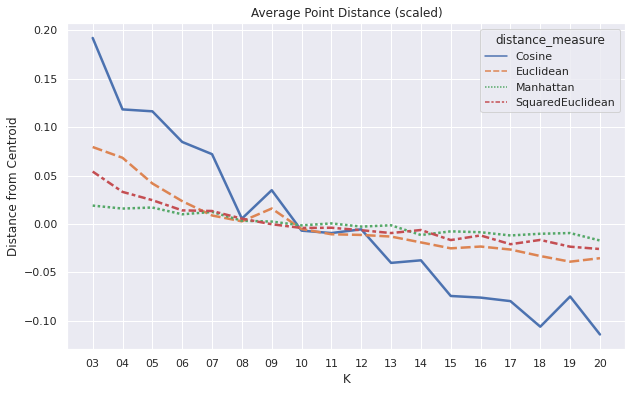

In [35]:
sns.lineplot(
    data=df_average_distance,
    x='k',
    y='scaled_point_distance',
    hue='distance_measure',
    style='distance_measure',
    linewidth=2.5).set(
        title='Average Point Distance (scaled)',
        xlabel='K',
        ylabel='Distance from Centroid')

[Text(0.5, 0, 'K')]

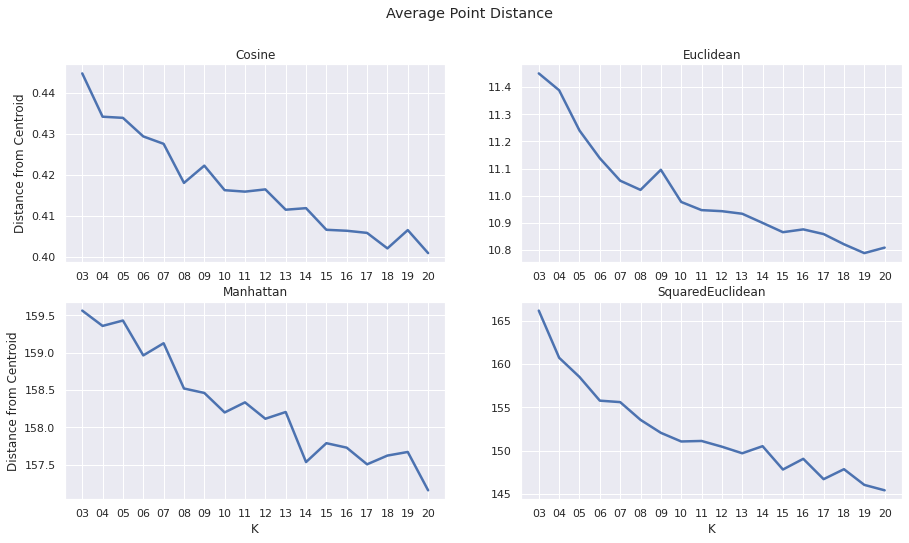

In [36]:
def plot_point_distance(distance_measure:str, axes=None):
    """
    Plot a line chart of the average distance from centroid for the specifice distance measure.
    """
    plot = sns.lineplot(
        data=df_average_distance.query('distance_measure == @distance_measure'),
        x='k',
        y='point_distance',
        ax=axes,
        linewidth=2.5)

    plot.set(
        title=distance_measure,
        xlabel='',
        ylabel='')

    return plot

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 8))
figure.suptitle('Average Point Distance')

# create separate plots for each distance measurement
plot_point_distance('Cosine', axes=axis[0,0]).set(ylabel='Distance from Centroid')
plot_point_distance('Euclidean', axes=axis[0,1])
plot_point_distance('Manhattan', axes=axis[1,0]).set(xlabel='K', ylabel='Distance from Centroid')
plot_point_distance('SquaredEuclidean', axes=axis[1,1]).set(xlabel='K')

### Density

https://journalofbigdata.springeropen.com/articles/10.1186/s40537-017-0087-2

"distances between objects exhibit high levels of intra-cluster similarity and low levels of inter-cluster similarity."

https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

"It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible."

#### Inter-Cluster Density

[Text(0.5, 1.0, 'Inter Cluster Density'),
 Text(0.5, 0, 'K'),
 Text(0, 0.5, 'Density')]

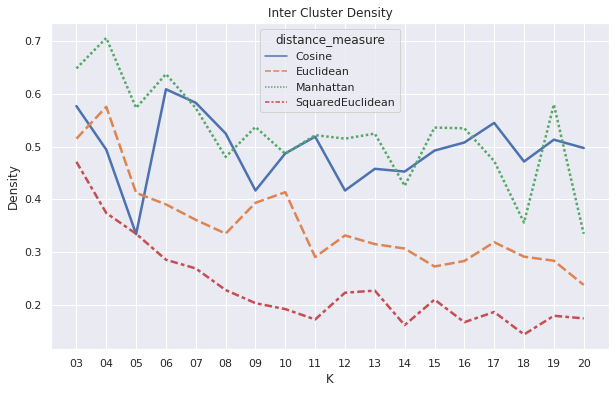

In [37]:
sns.set(rc={"figure.figsize":(10, 6)})

# plot inter cluster density
sns.lineplot(
    data=df_average_distance,
    x='k',
    y='inter_cluster_density',
    hue='distance_measure',
    style='distance_measure',
    linewidth=2.5).set(
        title='Inter Cluster Density',
        xlabel='K',
        ylabel='Density')

#### Intra-Cluster Density

[Text(0.5, 1.0, 'Intra Cluster Density'),
 Text(0.5, 0, 'K'),
 Text(0, 0.5, 'Density')]

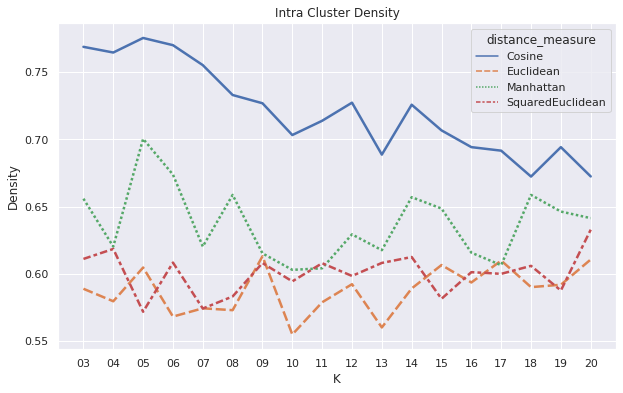

In [38]:
# plot intra cluster density
sns.lineplot(
    data=df_average_distance,
    x='k',
    y='intra_cluster_density',
    hue='distance_measure',
    style='distance_measure',
    linewidth=2.5).set(
        title='Intra Cluster Density',
        xlabel='K',
        ylabel='Density')

#### Density Ratio

[Text(0.5, 1.0, 'Density Ratio'), Text(0.5, 0, 'K'), Text(0, 0.5, 'Ratio')]

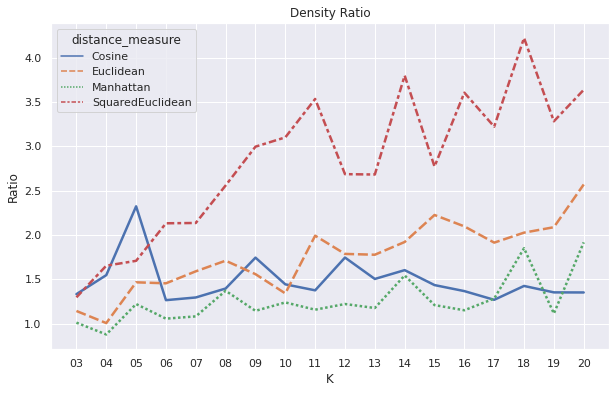

In [39]:
# plot inter cluster density
sns.lineplot(
    data=df_average_distance,
    x='k',
    y='density_ration',
    hue='distance_measure',
    style='distance_measure',
    linewidth=2.5).set(
        title='Density Ratio',
        xlabel='K',
        ylabel='Ratio')

### Elbow Method

In [40]:
# add a column for the squared distances
df_analysis['squared_distance'] = df_analysis.point_distance * df_analysis.point_distance

# create the grouping to draw the chart for the elbow method
df_distance_group = df_analysis.groupby(by=['distance_measure', 'k']).aggregate('sum')

[Text(0.5, 0, 'K')]

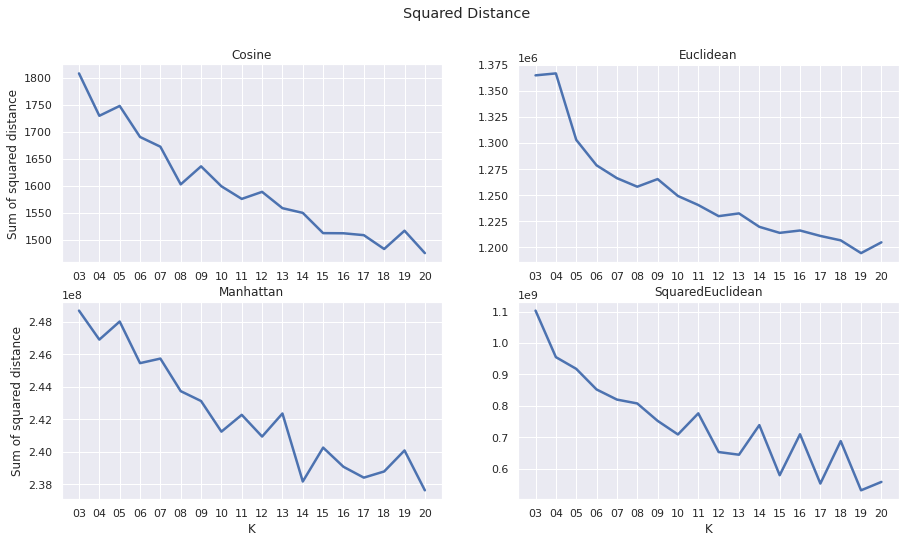

In [41]:
def plot_squared_distance(distance_measure:str, axes=None):
    """
    Plot a line chart of the squared distance from centroid for the specifice distance measure.
    """
    plot = sns.lineplot(
        data=df_distance_group.query('distance_measure == @distance_measure'),
        x='k',
        y='squared_distance',
        ax=axes,
        linewidth=2.5)

    plot.set(
        title=distance_measure,
        xlabel='',
        ylabel='')

    return plot

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 8))
figure.suptitle('Squared Distance')

# create separate plots for each distance measurement
plot_squared_distance('Cosine', axes=axis[0,0]).set(ylabel='Sum of squared distance')
plot_squared_distance('Euclidean', axes=axis[0,1])
plot_squared_distance('Manhattan', axes=axis[1,0]).set(xlabel='K', ylabel='Sum of squared distance')
plot_squared_distance('SquaredEuclidean', axes=axis[1,1]).set(xlabel='K')